In [24]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter
from gpflow.utilities import print_summary

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)


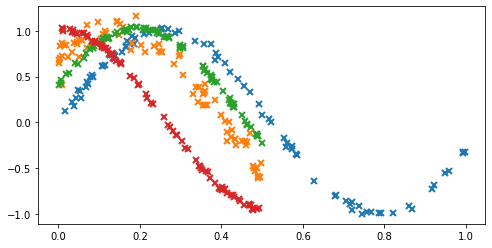

In [16]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(80, 1)  # Observed locations for first output
X2 = np.random.rand(80, 1) * 0.5 # Observed locations for second output
X3 = np.random.rand(80, 1) * 0.5
X4 = np.random.rand(80, 1) * 0.5

Y1 = np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1
Y3 = np.sin(6*X3 + 0.4) + np.random.rand(*X3.shape)*0.05
Y4 = np.cos(6*X4) + np.random.rand(*X4.shape)*0.05

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
_ = plt.plot(X2, Y2, "x", mew=2)
_ = plt.plot(X3, Y3, "x", mew=2)
_ = plt.plot(X4, Y4, "x", mew=2)


In [17]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2))), np.hstack((X3, np.ones_like(X3)*2)), np.hstack((X4, np.ones_like(X4)*3))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2))), np.hstack((Y3, np.ones_like(Y3)*2)),np.hstack((Y4, np.ones_like(Y4)*3))))


In [18]:
output_dim = 4  # Number of outputs
rank = 1  # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg

In [20]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)


      fun: -587.1573201734325
 hess_inv: <51694x51694 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.09399101e-01, -5.68746321e-02,  6.76206335e-02, ...,
        5.95187823e-06, -3.04174411e-08,  1.01893348e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5461
      nit: 5132
   status: 0
  success: True
        x: array([ 4.98092138e-01, -5.93806723e-01, -2.16863776e+00, ...,
        2.94675052e-04,  7.89762315e-09,  9.99272083e-01])

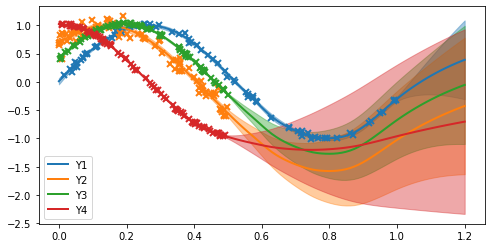

In [23]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 1.2, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")
    
    (line,) = plt.plot(X3, Y3, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, 2*np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y3")
    
    (line,) = plt.plot(X4, Y4, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, 3*np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y4")

    plt.legend()


plot(m)



B = [[5.74143235 4.23399645 4.78080045 1.04182573]
 [4.23399645 4.4771601  4.30404769 0.9379324 ]
 [4.78080045 4.30404769 4.86738063 1.05906268]
 [1.04182573 0.9379324  1.05906268 3.33170454]]


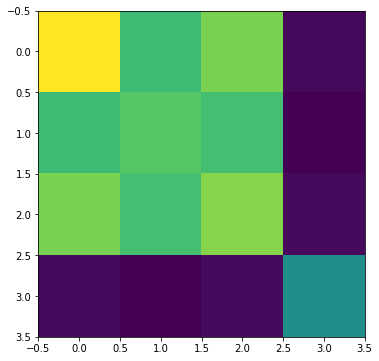

In [22]:
B = coreg.output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

In [25]:
print_summary(m)

╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                 │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ VGP.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.43968688955531265                                   │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────────────────────────────────┤
│ VGP.kernel.kernels[0].lengthscales     │ Parameter │ Softplus         │         │ True        │ ()